# Using RAPIDS cuML 
**Rapids** is an open-source data analytics and machine learning acceleration platform created by **NVIDIA** <br>
* leverages GPUs to accelerate computations<br>
* based on Python, has pandas-like and Scikit-Learn-like interfaces<br>
* built on Apache Arrow in-memory data format<br>
* can scale from 1 to multi-GPU to multi-nodes<br>

### ssh into Polaris login node
1. ssh into one of Polaris' login nodes <br>
`ssh username@polaris.alcf.anl.gov` <br>

Clone the project repository into your home directory:<br>
git clone https://github.com/argonne-lcf/ALCF_Hands_on_HPC_Workshop/ <br>
cd /ALCF_Hands_on_HPC_Workshop/Scikit-learn<br>
Copy files: `start_rapids_cluster_polaris.sh`, `start_rapids_cluster_rank.sh` and `activate_rapids_env_polaris.sh` to your $HOME dir and change their permisions (e.g. using `chmod 755 activate_rapids_env_polaris.sh`)

### Start a Dask-RAPIDS cluster on Polaris

2. ##### <a href='https://docs.alcf.anl.gov/polaris/running-jobs/' target="_blank">Submit an interactive job</a> on n (here 1) nodes 
    `qsub -l select=1:system=polaris -l filesystems=home:eagle:grand -l walltime=00:30:00 -I -A YourProject -q YourQueue` 
A shell opens up on one of the compute nodes <br>
4. Run the script, `start_rapids_clusters_polaris.sh`. This will start the scheduler on the node with one worker per GPU.<br> 
If the cluster does not start, check the file `~/dask-local-directory/scheduler.json` and the log files of scheduler and workers in `~/dask-local-directory/logs/`


### Access the cluster from JupyterLab
1. Start a RAPIDS cluster
2. Establish a <a href="https://en.wikibooks.org/wiki/OpenSSH/Cookbook/Multiplexing" target='plain'>Multiplexed SSH Connection</a> to Polaris. Run the code below in your local machine, ensure to edit `YourUsername`<br>
`ssh -M -S ~/.ssh/multiplex:polaris.rapids YourUsername@polaris.alcf.anl.gov`
3. On a different terminal window in your local machine, run the script `open_jupyterlab_polaris.sh` to start a JupyterLab session on Polaris<br>
`./open_jupyterlab_polaris.sh <COMPUTE_NODE_ADDRESS>` <br>
where `<COMPUTE_NODE_ADDRESS>` is the compute node hostname, like `x3006c0s1b1n0`<br>
4. Copy the url that is returned by the script and paste it in a browser window to access JupyterLab and view the dashboards <br>
5. If it issued an ssh connection with control master error, open the script and replace `polaris` with <br>
`YourUsername@polaris.alcf.anl.gov`<br>

**Note**
If you get the `username@x3008c0s19b0n0: Permission denied (publickey,keyboard-interactive,hostbased)`error, it is likely because you do not have any SSH keypair created on Polaris and installed in the `~/.ssh/authorized_keys` list; the compute node is  therefore rejecting your direct SSH jump from the login node<br>
From a Polaris login node, run `ssh-keygen -t ed25519` and `ssh-copy-id polaris` <br>
Also, if you get the message `no control path specified for "-O" command`, you should consider using a global SSH multiplexing setup for all Polaris connections.<br>
From a Polaris login node:<br> 
`mkdir ~/.ssh/cm_socket/`
Then edit `~/.ssh/config` and add the following lines:<br>

`Host polaris` <br>
`HostName polaris.alcf.anl.gov` <br>
`User <INSERT username>` <br>
`ControlMaster auto` <br>
`ControlPath ~/.ssh/cm_socket/%r@%h:%p` <br>
`ControlPersist 10m` <br>
Then the Multiplex in step 2 turns from `ssh -M -S ~/.ssh/multiplex:polaris.rapids YourUsername@polaris.alcf.anl.gov` to simply `ssh polaris`

### On JupyterLab
Select the kernel with your RAPIDS' enviroment name (something like Python `[conda env:rapids-23.04_polaris]`) from the Kernel menu in the top right corner.<br>
if the RAPIDS' kernel is not present in the kernel menu, add it by activating the conda environment running the commands below on Polaris login node <br>
`2024-04-29//lus/grand/projects/alcf_training/rapids/polaris/rapids-23.04_polaris`<br>
`python -m ipykernel install --user --name "rapids-23.04" --display-name "Python [conda env:"rapids-23.04"]"`


### Accessing Project Folders
To access project directories located outside of your `$HOME`, a symbolic link to the directory must be created.<br>
**from terminal**<br>
cd ~
`ln -s /ALCF_Hands_on_HPC_Workshop/Scikit-learn`

**in notebook using `!` escape** <br>
`!ln -s /ALCF_Hands_on_HPC_Workshop/Scikit-learn`



### On Jupyter Notebook, Connect to the cluster with:

In [1]:
from dask.distributed import Client
import dask.distributed
import json
import pathlib
fname = f'{pathlib.Path.home().as_posix()}/dask-local-directory/scheduler.json'
with open(fname, 'r') as f:
    scheduler = json.load(f)
    client = dask.distributed.Client(scheduler['address'])
client

<Client: 'tcp://10.201.1.211:8786' processes=4 threads=4, memory=1.87 TiB>

### GPU Accelerated DBSCAN in RAPIDS

In [3]:
# Import the neccessary libraries
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import cudf
from cuml.dask.cluster import DBSCAN as daskDBSCAN
import time
import matplotlib.pyplot as plt
%matplotlib inline

**Generate Dataset**

In [4]:
# Generate synthetic data using make_blobs
centers = [[0, 0], [0, 1]]
X, _ = make_blobs(n_samples=180_000, centers=centers, cluster_std=0.09, random_state=0)


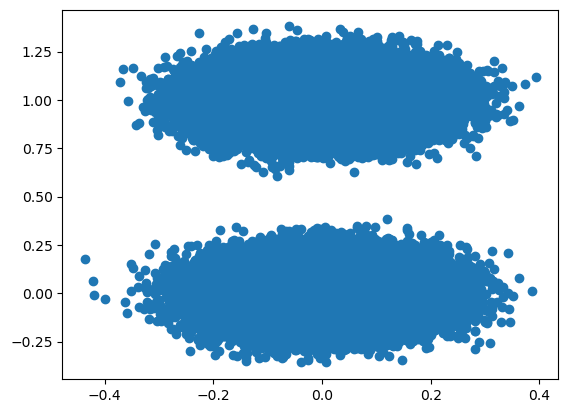

In [5]:
# Let's visualize our dataset
plt.scatter(X[:, 0], X[:, 1])
plt.show()

#### Train DBSCAN on GPU

In [6]:
# Convert data to cuDF DataFrame for GPU
X_df=pd.DataFrame(X)
X_gpu = cudf.DataFrame.from_pandas(X_df)

In [7]:
# Run DBSCAN on GPUs using cuML
start_time = time.time()
db_gpu = daskDBSCAN(eps=0.2, min_samples=10).fit(X_gpu)
gpu_time = time.time() - start_time
print(f"DBSCAN on GPU took: {gpu_time:.4f} seconds")

DBSCAN on GPU took: 12.0827 seconds


#### Train DBSCAN on CPU 

In [8]:
# Run DBSCAN on CPU using scikit-learn
start_time = time.time()
db_cpu = DBSCAN(eps=0.2, min_samples=20).fit(X)
cpu_time = time.time() - start_time
print(f"DBSCAN on CPU took: {cpu_time:.4f} seconds")

DBSCAN on CPU took: 85.2842 seconds


#### Compare results 

In [9]:
from sklearn.metrics import silhouette_score

cpu_labels = db_cpu.labels_
gpu_labels = db_gpu.labels_.to_pandas().values
silhouette_gpu = silhouette_score(X, gpu_labels)
print(f'Silhouette Score (GPU): {silhouette_gpu:.4f}')

silhouette_cpu = silhouette_score(X, cpu_labels)
print(f'Silhouette Score (CPU): {silhouette_cpu:.4f}')

Silhouette Score (GPU): 0.8405
Silhouette Score (CPU): 0.8405



### Shutdown the cluster with: 
`client.shutdown()`<br>
Then run the script `close_jupyterlab_polaris.sh` on your local machine to end the JupyterLab session and close the multiplexed connection<br>
Make sure to edit `YourUsername` on the script